# Persistance Forecast

#### Jose Valles (jose.valles.leon@gmail.com)

In [1]:
# Importing the libraries
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import seaborn as sns
import numpy as np
import calendar
import datetime
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline

from IPython.display import HTML

sns.set()

In [2]:
# Quantile Function Definitions
def q1(x):
    return x.quantile(0.25)

def q2(x):
    return x.median()

def q3(x):
    return x.quantile(0.75)

Import de daily discharge from a hydrological station located in Uruguay 

In [5]:
station_name = '1330'
DISCHARGE_DAILY = pd.read_csv(f'../data/{station_name}.csv',parse_dates=['Fecha'],index_col="Fecha",dayfirst=True,na_values="NA")

Identify the missing dates and change dataframe columns name. **Important** Change the end date parameter in the ``pd.date_range``

In [8]:
# Identify the missing data from a date range (1980 to 2023)
DISCHARGE_DAILY_date_missing = pd.date_range(start = DISCHARGE_DAILY.index[0].strftime('%Y-%m-%d'), end = DISCHARGE_DAILY.index[-1].strftime('%Y-%m-%d'),freq='D')
# Re-index the dataframe based on the missind date variable
DISCHARGE_DAILY = DISCHARGE_DAILY.reindex(DISCHARGE_DAILY_date_missing,fill_value=None)
# Set index Fecha
DISCHARGE_DAILY.index.name = 'date' 
# Change columns names
DISCHARGE_DAILY.columns = ['discharge']
# Print the last 6 values
HTML(DISCHARGE_DAILY.tail(6).to_html())

,discharge
date,
2024-08-26,69.730
2024-08-27,51.689
2024-08-28,36.475
2024-08-29,27.211
2024-08-30,24.313
2024-08-31,108.199


### Calculate monthly mean from daily data

First, we define a percentage of missing value. For this exercise, we use a 50% of missing data in the given month

In [9]:
# Percentage of missing data
max_pct_missing = 50

In [10]:
# group the Dataframe in a monthly time scale
GROUPER_DISCHARGE_MONTHLY = DISCHARGE_DAILY.groupby(pd.Grouper(freq='1MS'))

# this function allows to calculate the percentange of missing values and label the dataframe to "missing"
NUMBER_MISSING = GROUPER_DISCHARGE_MONTHLY.apply(lambda x: pd.isnull(x).sum()*100/len(x)).unstack(1)
NUMBER_MISSING = NUMBER_MISSING.to_frame()

# change the column name to "missing"
NUMBER_MISSING.columns = ['number_missing'] 

# this function allows to calculate the percentange of missing values and label the dataframe to "missing"
BOOL_MISSING = GROUPER_DISCHARGE_MONTHLY.apply(lambda x: pd.isnull(x).sum()*100/len(x)).unstack(1) < max_pct_missing
BOOL_MISSING = BOOL_MISSING.to_frame() # Convert to DataFrame
BOOL_MISSING.columns = ['missing'] # change the column name to "missing"

# BOOL_MISSING[~BOOL_MISSING['missing']] # print the dates that does not fulfill the criterion of null data in for each month
# BOOL_MISSING.to_clipboard()

# NUMBER_MISSING.to_clipboard() # Uncomment if you want to visualize all the result in a CSV

Next, we identify the months which contains lower that the max_pct_missing value and the monthly flow is only calculated if 50% o more of recorded value in a given month

In [11]:
# from daily to monthly
DISCHARGE_MONTHLY = DISCHARGE_DAILY.resample('M').apply(lambda x: x.mean() if x.isnull().sum()*100/len(x) < max_pct_missing else np.nan)
# from monthly to 3 months
DISCHARGE_THREE_MONTHS = DISCHARGE_MONTHLY.rolling(3).apply(lambda x: x.mean() if x.isnull().sum()*100/len(x) < max_pct_missing else np.nan)
# Create columns
DISCHARGE_MONTHLY['year'] = DISCHARGE_MONTHLY.index.year
DISCHARGE_MONTHLY['month'] = DISCHARGE_MONTHLY.index.month
## create column for day, month, year in the daily discharge ()
DISCHARGE_DAILY['year'] = DISCHARGE_DAILY.index.year
DISCHARGE_DAILY['month'] = DISCHARGE_DAILY.index.month
DISCHARGE_DAILY['monthday'] = DISCHARGE_DAILY.index.day_of_year
# Transform the date to Qlog
DISCHARGE_MONTHLY['Q_to_log'] = np.log(DISCHARGE_MONTHLY['discharge'])
## print the first results
HTML(DISCHARGE_MONTHLY.tail(6).to_html(index=False))
# DISCHARGE_MONTHLY.to_clipboard() # Uncomment if you want to visualize all the time serie

discharge,year,month,Q_to_log
804.603903,2024,3,6.690350
225.122000,2024,4,5.416642
285.273233,2024,5,5.653447
170.655692,2024,6,5.139648
20.642419,2024,7,3.027348
30.229759,2024,8,3.408827


### Select the period of record to estimate the mean and std

For this section, we will use a period of reference or the dataset of year overdue. We are in 2023 so the period of record is 1980-2022

In [26]:
DISCHARGE_SELECTION = DISCHARGE_MONTHLY[(DISCHARGE_MONTHLY['year'] >= 1981) & (DISCHARGE_MONTHLY['year'] <= 2010)]

Calculate the average dischare for each month in the period of record

In [27]:
DISCHARGE_MONTHLY_STATS = DISCHARGE_SELECTION.Q_to_log.groupby(DISCHARGE_SELECTION.index.month).agg([np.mean, np.std, q1, q3])
Q_MONTHLY_STATS = DISCHARGE_SELECTION.discharge.groupby(DISCHARGE_SELECTION.index.month).agg([np.mean, np.std, q1, q3])
# Display results
HTML(DISCHARGE_MONTHLY_STATS.to_html())

,mean,std,q1,q3
date,,,,
1,2.626677,1.150370,1.949613,3.422253
2,3.038425,1.362657,2.062796,3.484719
3,3.248518,1.215416,2.274073,3.977528
4,3.556972,1.306093,2.513809,4.395450
5,3.999733,1.292368,2.855299,5.000346
6,4.535713,1.129092,4.145857,5.255533
7,4.642919,0.940509,4.238399,5.179293
8,4.449805,0.964738,3.859566,5.198116
9,4.568496,0.908739,3.902018,5.128517


In [28]:
DISCHARGE_MONTHLY['anomaly'] = np.nan
for i in range(len(DISCHARGE_MONTHLY)):
    # Extract the current month 
    m = DISCHARGE_MONTHLY.month[i]
    # Extract the current year
    y = DISCHARGE_MONTHLY.year[i]
    DISCHARGE_MONTHLY.loc[DISCHARGE_MONTHLY.eval('month==@m & year==@y'),'anomaly'] = (DISCHARGE_MONTHLY['Q_to_log'][i] - DISCHARGE_MONTHLY_STATS.query('index == @m')["mean"].item()) / DISCHARGE_MONTHLY_STATS.query('index == @m')["std"].item()

DISCHARGE_MONTHLY = DISCHARGE_MONTHLY[['year','month','discharge','Q_to_log','anomaly']]

In [29]:
HTML(DISCHARGE_MONTHLY.tail(8).to_html(index=False))

year,month,discharge,Q_to_log,anomaly
2024.0,7.0,20.642419,3.027348,-1.717762
2024.0,8.0,30.229759,3.408827,-1.079027
2024.0,9.0,35.068824,3.557313,-1.112733
2024.0,10.0,17.913160,2.885536,-1.078131
2024.0,11.0,13.906682,2.632369,-1.101378
2024.0,12.0,6.517504,1.874491,-1.077957
2025.0,1.0,3.362884,1.212799,-1.229064
2025.0,2.0,4.762309,1.560733,-1.084420


### Make a Persistance Forecast

We create a function called add_month that add the number of months based on an input date.

In [30]:
def add_months(sourcedate, months):
    month = sourcedate.month - 1 + months
    year = sourcedate.year + month // 12
    month = month % 12 + 1
    day = min(sourcedate.day, calendar.monthrange(year,month)[1])
    date_result = datetime.date(year, month, day)
    date_result = date_result.strftime('%Y-%m-%d %H:%M:%S')
    date_result = datetime.datetime.strptime(date_result,'%Y-%m-%d %H:%M:%S')
    return date_result

We extract the month overdue based on the current date

In [31]:
# today = datetime.datetime(2022, 1, 1) # Uncomment if you would like to specify a date
today = datetime.date.today() # Uncomment if you would like to use today date
first = today.replace(day=1)
last_month = first - datetime.timedelta(days=1)
# last_month = DISCHARGE_MONTHLY.index[-1] # Uncomment if you would like to use the last date in the df
print(last_month.strftime('%Y-%m-%d'))

2024-08-31


Make a Forecast and create a new dataframe for forecasting purposes 

In [32]:
# Make a Forecast using the persistance of the discharge anomaly
PERSISTANCE_FCST = DISCHARGE_MONTHLY.query("month == @last_month.month & year == @last_month.year")['anomaly'].item()
# For the forecast, we will create a new dataframe 
DISCHARGE_MONTHLY_FCST = DISCHARGE_MONTHLY

In [33]:
# Define the forecast lead-times
arr = np.array([1,2,3,4,5,6])
for x in arr:
    # convert to datetime the forecast lead-time
    forecast_month = add_months(last_month,x)
    # revert anomaly transformation
    q2log = (PERSISTANCE_FCST * DISCHARGE_MONTHLY_STATS.query('index == @forecast_month.month')["std"].item()) + DISCHARGE_MONTHLY_STATS.query('index == @forecast_month.month')["mean"].item()
    # Revert forecast to obtain flow units
    exp_log = np.exp(q2log)
    # put it in the forecast dataframe
    DISCHARGE_MONTHLY_FCST.loc[forecast_month] = [forecast_month.year,forecast_month.month, exp_log, q2log, PERSISTANCE_FCST]

# DISCHARGE_MONTHLY_FCST.index = DISCHARGE_MONTHLY_FCST.index.map(lambda t: t.replace(day=1))

In [34]:
HTML(DISCHARGE_MONTHLY_FCST.tail(8).to_html(index=True))

,year,month,discharge,Q_to_log,anomaly
date,,,,,
2024-07-31,2024.0,7.0,20.642419,3.027348,-1.717762
2024-08-31,2024.0,8.0,30.229759,3.408827,-1.079027
2024-09-30,2024.0,9.0,36.159620,3.587943,-1.079027
2024-10-31,2024.0,10.0,17.894265,2.884480,-1.079027
2024-11-30,2024.0,11.0,14.288000,2.659420,-1.079027
2024-12-31,2024.0,12.0,6.510076,1.873351,-1.079027
2025-01-31,2025.0,1.0,3.996413,1.385397,-1.079027
2025-02-28,2025.0,2.0,4.797434,1.568081,-1.079027


In [35]:
ndata = DISCHARGE_MONTHLY_FCST.iloc[(DISCHARGE_MONTHLY_FCST.index >= '2023-10-01') & (DISCHARGE_MONTHLY_FCST.index <= '2025-04-30')]

In [36]:
ndata.index = ndata.index.map(lambda t: t.replace(day=1))

In [37]:
# create empty columns in the dataframe
ndata['25th_percentile'] = np.nan
ndata['75th_percentile'] = np.nan

for i in range(len(ndata)):
    # Extract the current month 
    m = ndata.month[i]
    y = ndata.year[i]
    ndata.loc[ndata.eval('month==@m & year==@y'),'25th_percentile']  = Q_MONTHLY_STATS.query('index==@m')['q1'].item()
    ndata.loc[ndata.eval('month==@m & year==@y'),'75th_percentile']  = Q_MONTHLY_STATS.query('index==@m')['q3'].item()

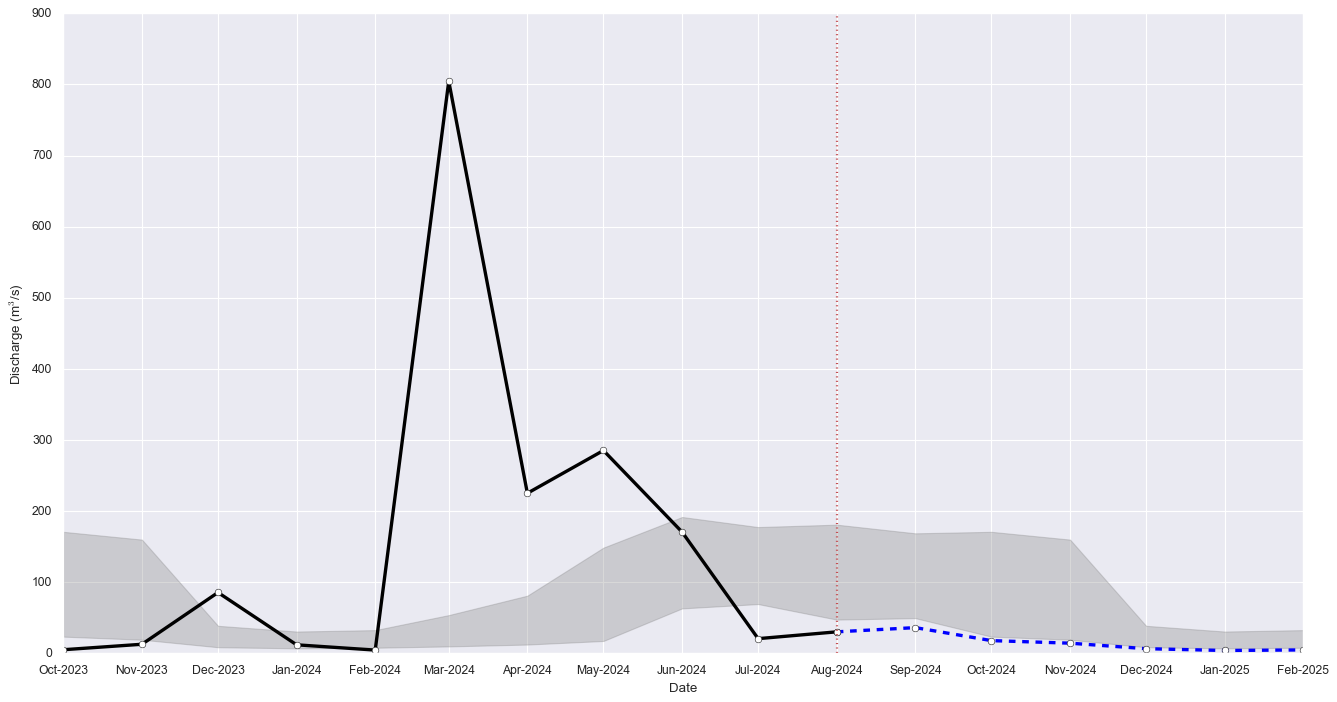

In [38]:
import matplotlib.dates as mdates

y1 = ndata.iloc[ndata.index <= last_month.replace(day=1).strftime('%Y-%m-%d')]
y2 = ndata.iloc[ndata.index >= last_month.replace(day=1).strftime('%Y-%m-%d')]

fig1, ax1 = plt.subplots(figsize=(20, 10))
ax1.plot(y1.index,y1['discharge'],linestyle = '-', color = 'black',linewidth=3, marker='o', mfc='white', mec='k')
ax1.plot(y2.index,y2['discharge'],linestyle = '--', color = 'blue', linewidth=3, marker='o', mfc='white', mec='k')
ax1.set_xlabel('Date');
ax1.set_ylabel('Discharge (m$^3$/s)');
# ax1.set_ylim([0,60])
ax1.axvline(x = last_month.replace(day=1), color = 'r',label = 'now', linestyle=':', linewidth=2, mfc='white', mec='k');

ax1.fill_between(ndata.index, ndata['25th_percentile'], ndata['75th_percentile'], color='grey', alpha=0.3,label="Inferior a lo normal")

ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))   #to get a tick every 1 month
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))   #optional formatting 
plt.xticks(rotation=0);

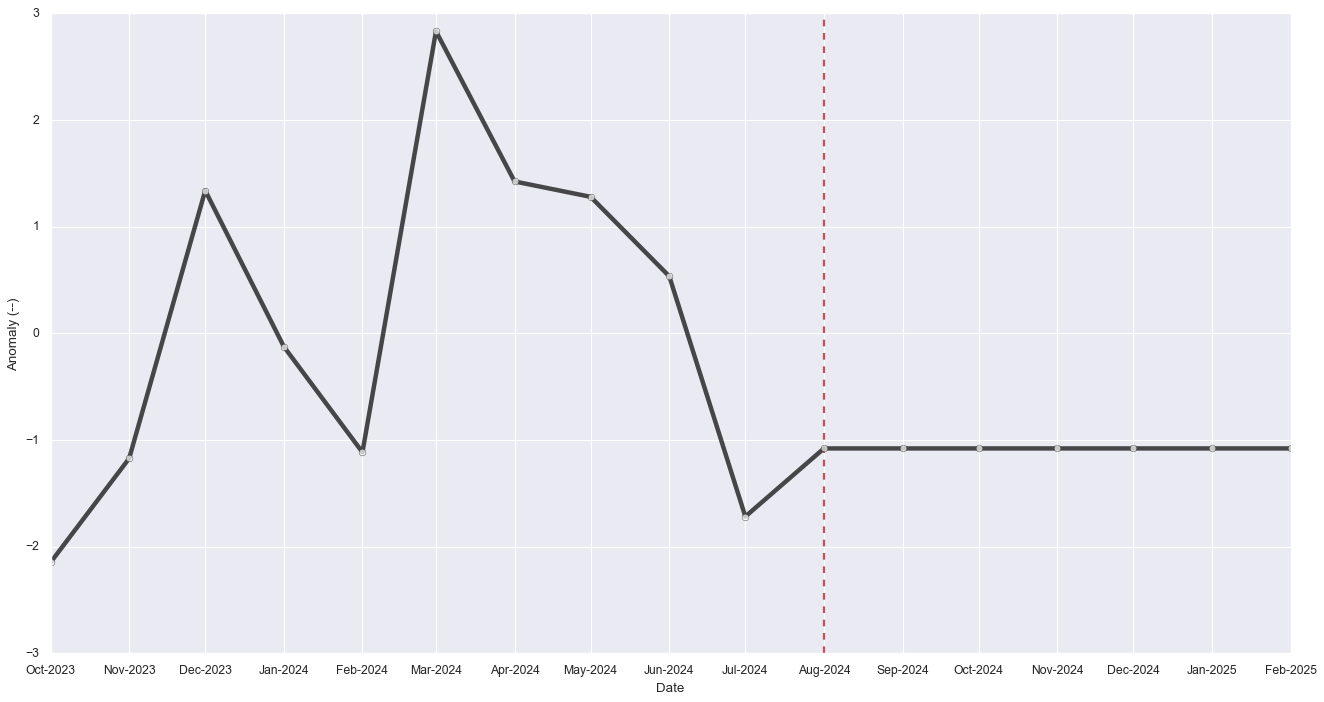

In [39]:
fig3, ax3 = plt.subplots(figsize=(20, 10))

ax3.axvline(x = last_month.replace(day=1), color = 'r',label = 'now', linestyle='--', linewidth=2, mfc='white', mec='k');
ax3.set_xlabel('Date');
ax3.set_ylabel('Anomaly (--)');

ax3.plot(ndata.index, ndata['anomaly'],marker='o', color='black', linewidth=4, alpha=0.7,mfc='white', mec='k')

# ax1.set_ylim([0,20]);
ax3.xaxis.set_major_locator(mdates.MonthLocator(interval=1))   #to get a tick every 1 month
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))   #optional formatting 
plt.xticks(rotation=0);